# From QoS Measurements to QoE Distribution

An example is provided which uses the scripts to approximate the QoE distribution 
in a system based on QoS measurements and an existing MOS mapping function. 

This tool is published under the license CC BY-SA 4.0 at
https://github.com/hossfeld/approx-qoe-distribution 

The following paper is to be cited in the bibliography whenever the tool is used.
_Tobias Hossfeld, Poul E. Heegaard, Martin Varela, Lea Skorin-Kapov, Markus Fiedler. 
    "From QoS Distributions to QoE Distributions: a System's Perspective". 
    4th International Workshop on Quality of Experience Management (QoE Management 2020), 
    featured by IEEE Conference on Network Softwarization (IEEE NetSoft 2020), Ghent, Belgium._

Created on Thu Mar 26 21:51:00 2020
@author: Tobias Hossfeld

## QoS Measurements in the System
We measure the relevant QoS parameters in the system which are captured as numpy array `qos`.

Then, we use an existing MOS mapping function $f(x)$ which maps the QoS value $x$ to the MOS value $f(x)$. Here we use a 5-point rating scale with MOS values in the range [1;5].

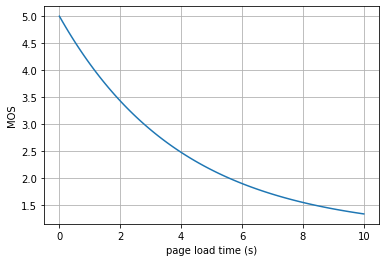

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import approxQoEdist as app

#%% QoS measurements in the system 
k = 100
qos = np.abs(np.random.randn(k)*2+0.6) # here randomly generated values

#%% Literature provides a MOS mapping function f
f = lambda x: 4*np.exp(-0.25*x)+1
x = np.linspace(0,10,100)
plt.plot(x,f(x))
plt.xlabel('page load time (s)')
plt.ylabel('MOS')
plt.grid(which='major');

## QoE Distribution in the System
For each of the measured QoS values $x$, we obtain the MOS value $f(x)$. We approximate the user rating distribution $D_x$ for QoS $x$ based on the discrete Beta approximation with the default SOS parameter $a=0.25$. 
Hence, for the QoS $x$, we obtain $p_{k,x}=P(D_x=k)$

We have $n$ measurement of QoS values in total. Then, the distribution of the QoE ratings in the system (over all QoS measurement) is as follows (with $x_i$ specifying the QoS values for $i=1,\dots,n$.
$$p_k = P(D=k) = \frac{1}{n}\sum_{i=1}^n p_{k,x_i}$$

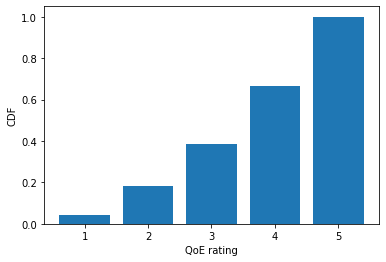

In [3]:
#%% Derive QoE distribution in the system using a discrete 5-point scale
xk = np.arange(1,6) # The (discrete) QoE ratings (1,2,3,4,5)
pk = np.zeros(5) # Probability for QoE rating in the system: P(D=k) 
for mos in f(qos):
    xkmos, pkmos = app.getDiscreteDistributionArrays(mos) # P(D_x=k) 
    pk += pkmos
pk /= len(qos)     

#%% Plot the QoE distribution and relevant QoE metrics
plt.figure(11)
plt.clf()
plt.bar(xk,pk.cumsum(), label='sytem QoE')
plt.xlabel('QoE rating')
plt.ylabel('CDF');

## QoE Metrics
In the following, we compute the MOS, GoB (ratio of users rating 'good or better') and PoW (ratio of users rating 'poor or worse') as QoE metrics. We can simply use the QoE distribution $Q$ to derive those measures.

We can also derive those QoE metrics using the fundamental relationships paper. 
_Hoßfeld, T., Heegaard, P. E., Skorin-Kapov, L., & Varela, M. (2019, June). 
Fundamental Relationships for Deriving QoE in Systems. 
In 2019 Eleventh Int. Conf. on Quality of Multimedia Experience (QoMEX) (pp. 1-6). IEEE._

QoE metrics in the system for QoS measurements $X$ on a scale from 1 to 5:
* Expected QoE $E[Q] = E[f(X)]$ with a MOS mapping function $g(x)$
* GoB ratio $GoB[Q]=P(Q \geq 4) = E[g(X)]$ with a GoB mapping function $g(x)$
* PoW ratio $PoW[Q]=P(Q \leq 2) = E[w(X)]$ with a PoW mapping function $w(x)$


Expected system QoE: E[D]=3.69 vs. E[f(X)]=3.71
Poor or worse ratio in the system: PoW[D]=0.18 vs. E[w(X)]=0.18
Good or better ratio in the system: GoB[D]=0.61 vs. E[g(X)]=0.61


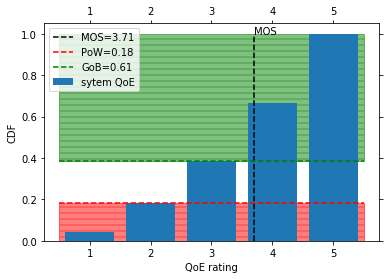

In [4]:
#%% Plot the QoE distribution and relevant QoE metrics
plt.bar(xk,pk.cumsum(), label='sytem QoE')
plt.xlabel('QoE rating')
plt.ylabel('CDF')

# Compare the exact expected QoE $E[f(X)]$ with the discrete beta approximation 
mos_vals = f(qos)
print(f'Expected system QoE: E[D]={np.sum(pk[1:]*xk[1:]):.2f} vs. E[f(X)]={mos_vals.mean():.2f}')
plt.plot([mos_vals.mean()]*2, [0, 1], 'k--', label=f'MOS={mos_vals.mean():.2f}')
plt.text(mos_vals.mean(),1, 'MOS')
plt.gca().tick_params(right=True, top=True, labeltop=True)

pow_vals = np.array([app.getPoW(mos) for mos in f(qos)])
print(f'Poor or worse ratio in the system: PoW[D]={pk[:2].sum():.2f} vs. E[w(X)]={pow_vals.mean():.2f}')
plt.plot([0.5,5.5], [pow_vals.mean()]*2, 'r--', label=f'PoW={pow_vals.mean():.2f}')
plt.fill_between([0.5,5.5], 0, [pow_vals.mean()]*2, color='r', alpha=0.5, zorder=-1, hatch='--')

gob_vals = np.array([app.getGoB(mos) for mos in f(qos)])
print(f'Good or better ratio in the system: GoB[D]={pk[-2:].sum():.2f} vs. E[g(X)]={gob_vals.mean():.2f}')
plt.plot([0.5,5.5], [1-gob_vals.mean()]*2, 'g--', label=f'GoB={gob_vals.mean():.2f}')
plt.fill_between([0.5,5.5], [1-gob_vals.mean()]*2, 1, color='g', alpha=0.5, zorder=-1, hatch='--')

plt.legend();

### Why is there a difference between $E[D]$ and $E[f(X)]$ ?
In fact, the Beta approximation returns a continuous random variable $Q$. For obtaining a discrete random variable $D$, the random variable is rounded: $ D = [Q]$.

The (exact) expected QoE in the system is $E[f(X)]=E[Q]$, see [QoMEX 2019]. For the $n$ QoS measurements $(x_1,\dots,x_n)$, we can simply use the MOS mapping function $f(x)$ and obtain the expected QoE (which is the average MOS).
$$E[Q] = E[f(X)] = \frac{1}{n} \sum_{k=1}^n f(x_k) $$

We can also use the (exakt) probability density function $h_Q(t)$ to derive the expected system QoE.
$$h_Q(t) = \frac{1}{n} \sum_{k=1}^n h_{Q|x_k}(t) $$
Then, the expected value is accordingly
$$E[Q] = \int_t t \cdot h_Q(t) dt$$


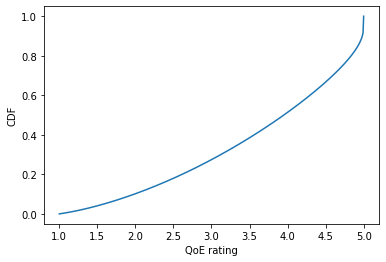

In [14]:
# Definition of the CDF based on the QoS measurement values
def Hq(t):
    if t<=1:
        return 0
    if t>=5:
        return 1
    else:        
        return np.mean([app.getBetaCDF(t, mos) for mos in f(qos)])
# Plot the CDF P(Q <= x)
t = np.linspace(1,5,500)
plt.plot(t, np.array([Hq(z) for z in t]));
plt.xlabel('QoE rating')
plt.ylabel('CDF');

### Is the GoB ratio and PoW ratio derivation exact? 
The answer is 'yes'. Let us consider the 5-point scale. It is 
$$P(D=i) = P([Q]=i)=\int_{i-0.5}^{i+0.5} q(t) dt \quad \text{ for } \, i=1,\dots,5$$ 
Then, we have
$$ GoB[D] = P(D=4)+P(D=5) = \int_{3.5}^{4.5} q(t) dt + \int_{4.5}^{5} q(t) dt = P(Q \geq 3.5) = GoB[Q]$$

## References
* **[QoEMan2020]** Tobias Hossfeld, Poul E. Heegaard, Martin Varela, Lea Skorin-Kapov, Markus Fiedler. _"From QoS Distributions to QoE Distributions: a System's Perspective"_. 4th International Workshop on Quality of Experience Management (QoE Management 2020), featured by IEEE Conference on Network Softwarization (IEEE NetSoft 2020), Ghent, Belgium.
* **[QoMEX2019]** Tobias Hossfeld, Poul E. Heegaard, Martin Varela, Lea Skorin-Kapov. _"Fundamental Relationships for Deriving QoE in Systems."_ In 2019 Eleventh Int. Conf. on Quality of Multimedia Experience (QoMEX 2019), Berlin, Germany. 